https://www.kaggle.com/halien/simple-image-classifer-with-svm


https://www.kaggle.com/ambarish/retinal-oct-image-analysis/data

https://www.kaggle.com/paultimothymooney/kermany2018/kernels



https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from os import listdir
from glob import glob
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import skimage
from skimage import transform
from skimage.transform import resize
import scipy
from scipy.misc import imresize, imread
import keras
from keras import models, layers, optimizers
import sklearn
from sklearn.utils import class_weight


from skimage.color import rgb2gray
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'val', 'train']


In [3]:
listdir('../input/val')
listdir('../input/test')
listdir('../input/train')

['CNV', 'DRUSEN', 'DME', 'NORMAL']

In [4]:
val_path = '../input/val/'
test_path = '../input/test/'
train_path = '../input/train/'

In [5]:
listdir(train_path + 'NORMAL')[0:10]

['NORMAL-1102707-1.jpeg',
 'NORMAL-2197972-13.jpeg',
 'NORMAL-3991858-4.jpeg',
 'NORMAL-1114127-18.jpeg',
 'NORMAL-4310826-12.jpeg',
 'NORMAL-4591890-8.jpeg',
 'NORMAL-3985061-11.jpeg',
 'NORMAL-2072690-4.jpeg',
 'NORMAL-4987532-8.jpeg',
 'NORMAL-6324579-2.jpeg']

In [6]:
listdir(train_path + 'DRUSEN')[0:10]

['DRUSEN-732516-49.jpeg',
 'DRUSEN-732516-40.jpeg',
 'DRUSEN-589252-5.jpeg',
 'DRUSEN-482704-3.jpeg',
 'DRUSEN-224974-33.jpeg',
 'DRUSEN-364469-54.jpeg',
 'DRUSEN-956663-34.jpeg',
 'DRUSEN-482704-10.jpeg',
 'DRUSEN-482704-13.jpeg',
 'DRUSEN-783692-5.jpeg']

In [7]:
train_normal_image = cv2.imread(train_path + 'NORMAL/NORMAL-1027133-2.jpeg')

In [8]:
train_normal_image.shape

(496, 512, 3)

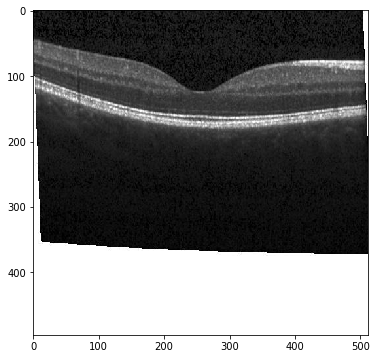

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(train_normal_image)

In [10]:
test_img_file = rgb2gray(skimage.transform.resize(train_normal_image, (256, 256, 3),anti_aliasing=True)) #,anti_aliasing_sigma=True, 

/home/isuf/anaconda3/envs/env_tf_gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


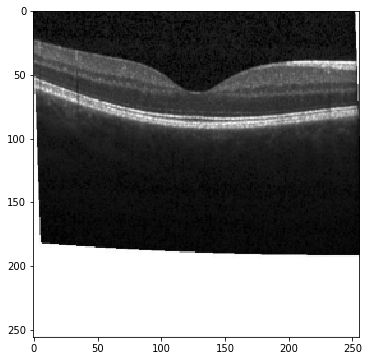

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(test_img_file,  cmap='gray')

In [12]:
#helper function to load data from file directory
imageSize =300
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3), anti_aliasing=True) # anti_aliasing Gaussian smoothing to avoid aliasing artifacts
                    grayscale = rgb2gray(img_file) # convert to grayscale
                    img_arr = grayscale.ravel() # reshape to 1d
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y




In [13]:
# load test data
x_test_features, y_test_label_target = get_data(test_path)

100%|██████████| 301/301 [00:09<00:00, 31.16it/s]


In [14]:
# load train data
x_train_features, y_train_label_target = get_data(train_path)

100%|██████████| 700/700 [00:22<00:00, 31.52it/s]


In [15]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import logging
from time import time



print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

t0 = time()

pca = PCA(n_components = 0.95)
svc = SVC(kernel='rbf')
model = make_pipeline(pca, svc)


from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [10,15,20], 'svc__gamma': [0.0001, 0.0005, 0.001]}
grid = GridSearchCV(model, param_grid, cv = 5)

%time grid.fit(x_train_features,y_train_label_target)

print("done in %0.3fs" % (time() - t0))


Automatically created module for IPython interactive environment
CPU times: user 9h 34min 59s, sys: 1h 13min 41s, total: 10h 48min 41s
Wall time: 1h 30min 7s
done in 5407.921s


In [16]:
print("Best estimator found by grid search:")
print(grid.best_params_)

Best estimator found by grid search:
{'svc__C': 20, 'svc__gamma': 0.0001}


In [17]:
##save mode 
import pickle
from sklearn.externals import joblib
joblib.dump(grid, 'svm_grid_rbf_v1.pkl') 

# load
#clf = joblib.load('filename.pkl') 

['svm_grid_rbf_v1.pkl']

In [18]:
# now to Now predict the value of the digit on the test data
y_predv3 = grid.predict(x_test_features)

In [19]:
from sklearn.metrics import classification_report

target_names = ['0-NORMAL', '1-CNV', '2-DME', '3-DRUSEN']
print(classification_report(y_test_label_target, y_predv3, target_names=target_names))



#print("Classification report for classifier %s:\n%s\n"
#      % (classifier, metrics.classification_report(y_test_label_target, y_pred)))

              precision    recall  f1-score   support

    0-NORMAL       0.59      0.73      0.65       300
       1-CNV       0.61      0.55      0.58       300
       2-DME       0.51      0.48      0.49       300
    3-DRUSEN       0.63      0.58      0.61       300

   micro avg       0.59      0.59      0.59      1200
   macro avg       0.59      0.59      0.58      1200
weighted avg       0.59      0.59      0.58      1200



In [20]:
#labels = ["0-NORMAL", "1-CNV", "2-DME","3-DRUSEN"] )
from sklearn.metrics import confusion_matrix
print("Confusion matrix:\n%s" % confusion_matrix(y_test_label_target, y_predv3))

Confusion matrix:
[[220  43  27  10]
 [ 85 164  42   9]
 [ 40  32 144  84]
 [ 27  28  70 175]]


In [15]:
# load
import pickle
from sklearn.externals import joblib
svm_grid_rbf_v1 = joblib.load('svm_grid_rbf_v1.pkl') 

In [16]:
# now to Now predict the value of the digit on the test data
y_pred = svm_grid_rbf_v1.predict(x_test_features)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_label_target, y_pred)

0.5858333333333333

In [25]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import logging
from time import time



print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

t0 = time()

pca = PCA(n_components = 0.80)
svc = SVC(kernel='poly')
model = make_pipeline(pca, svc)


from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [10,15], 'svc__gamma': [0.0001, 0.0005]}
grid = GridSearchCV(model, param_grid, cv = 3)

%time grid.fit(x_train_features,y_train_label_target)

print("done in %0.3fs" % (time() - t0))


Automatically created module for IPython interactive environment
CPU times: user 1h 56min 6s, sys: 16min 24s, total: 2h 12min 30s
Wall time: 21min 22s
done in 1283.638s


In [26]:
print("Best estimator found by grid search:")
print(grid.best_params_)

Best estimator found by grid search:
{'svc__C': 15, 'svc__gamma': 0.0005}


In [27]:
##save mode 
import pickle
from sklearn.externals import joblib
joblib.dump(grid, 'svm_grid_poly_v1.pkl') 

# load
#clf = joblib.load('filename.pkl') 

['svm_grid_poly_v1.pkl']

In [28]:
# now to Now predict the value of the digit on the test data
y_predv3 = grid.predict(x_test_features)

In [29]:
from sklearn.metrics import classification_report

target_names = ['0-NORMAL', '1-CNV', '2-DME', '3-DRUSEN']
print(classification_report(y_test_label_target, y_predv3, target_names=target_names))


              precision    recall  f1-score   support

    0-NORMAL       0.55      0.68      0.61       300
       1-CNV       0.53      0.51      0.52       300
       2-DME       0.49      0.44      0.46       300
    3-DRUSEN       0.62      0.56      0.59       300

   micro avg       0.55      0.55      0.55      1200
   macro avg       0.55      0.55      0.54      1200
weighted avg       0.55      0.55      0.54      1200



In [30]:
#labels = ["0-NORMAL", "1-CNV", "2-DME","3-DRUSEN"] )
from sklearn.metrics import confusion_matrix
print("Confusion matrix:\n%s" % confusion_matrix(y_test_label_target, y_predv3))

Confusion matrix:
[[204  63  23  10]
 [ 97 152  41  10]
 [ 45  42 132  81]
 [ 28  30  74 168]]


In [18]:
# load
import pickle
from sklearn.externals import joblib
svm_grid_poly_v1 = joblib.load('svm_grid_poly_v1.pkl') 

In [19]:
# now to Now predict the value of the digit on the test data
y_pred = svm_grid_poly_v1.predict(x_test_features)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_label_target, y_pred)

0.5466666666666666